In [1]:
# pip install pandas numpy scikit-learn matplotlib tensorflow

In [2]:
import pandas as pd
import numpy as np
import IPython
import IPython.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, Flatten, Attention
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [3]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPricesMerged.csv')

In [4]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [5]:
# Extract the relevant columns for oil sentiment data
oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
# oil_data = data[['Price']]
# oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil']]
oil_data.head()

,Price,neg_oil,neu_oil,pos_oil,compound_oil,neg_war,neu_war,pos_war,compound_war
Date,,,,,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.000,0.000,0.0000,0.000,0.776,0.224,0.9866
2023-04-10,84.180000,0.086,0.816,0.098,0.9796,0.144,0.708,0.147,-0.1356


In [6]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))
# oil_data = scaler.fit_transform(oil_data)

n = len(oil_data)
train_df = oil_data[0:int(n*0.7)]
val_df = oil_data[int(n*0.7):int(n*0.875)]
test_df = oil_data[int(n*0.875):]

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def all_data(self):
  return self.make_dataset(oil_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.all_data = all_data
WindowGenerator.example = example

In [8]:
val_performance = {}
performance = {}
histories={}
models_list={}
windows_list={}

windows_dictionary = {
    # 'weekly': 7, 
    'bi-weekly': 14, 
    # 'monthly': 30,       
}


In [9]:
for w in windows_dictionary:
    input_width=windows_dictionary[w]
    window = WindowGenerator(
        input_width=input_width, label_width=1, shift=1,
        label_columns=['Price']
    )
    windows_list[w]=window

In [10]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, early_patience=10, lr_patience=5):
  # Define the callbacks with the current parameters
  early_stopping = EarlyStopping(monitor='val_loss', patience=early_patience, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=lr_patience)
  callbacks = [early_stopping, reduce_lr]

  model.compile(
    # loss='mean_absolute_percentage_error',
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=[
      tf.keras.metrics.MeanAbsolutePercentageError(),
      # tf.keras.metrics.MeanSquaredError()
      tf.keras.metrics.MeanAbsoluteError(),
    ]
  )

  history = model.fit(
    window.train, 
    epochs=MAX_EPOCHS, 
    validation_data=window.val,
    callbacks=callbacks
  )

  return history

In [11]:
train_df.shape

(189, 9)

In [12]:
#best LSTM model -  get_bidirectional_lstm_model_4
def get_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model


In [13]:
# best cnn model - 1D CNN with Residual Connections
from tensorflow.keras.layers import Add

def get_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    residual = Conv1D(filters=64, kernel_size=1, padding='same')(inputs)
    x = Add()([x, residual])
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model



In [14]:
def get_average_ensemble_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    model1 = get_lstm_model(input_shape)
    model2 = get_cnn_model(input_shape)

    y1 = model1(inputs)
    y2 = model2(inputs)
    
    outputs = layers.average([y1, y2])
    ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
    return ensemble_model

In [15]:
def get_concatenate_ensemble_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    model1 = get_lstm_model(input_shape)
    model2 = get_cnn_model(input_shape)

    y1 = model1(inputs)
    y2 = model2(inputs)
    
    ensemble_model=layers.concatenate([y1, y2])
    layer_1 = Dense(units=64, activation='relu')(ensemble_model)
    layer_2 = Dense(units=32, activation='relu')(layer_1)
    layer_3 = Dense(units=8, activation='relu')(layer_2)

    outputs = Dense(units=1, activation='relu')(layer_3)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [16]:
models_name_list={
    'average_ensemble_model' : get_average_ensemble_model ,
    'concatenate_ensemble_model' : get_concatenate_ensemble_model ,
}
models_list={}

In [17]:
for model_type in models_name_list:
    print(model_type)

average_ensemble_model
concatenate_ensemble_model


In [18]:
def create_model_for_each_model_type(model_type,early_patience , lr_patience):
    for window_name in windows_dictionary:
        seq_length=windows_dictionary[window_name]
        window = windows_list[window_name]
        input_shape=(seq_length, train_df.shape[1])


        model_name=f'{model_type}_{window_name}_{early_patience}_{lr_patience}'
        print('\n\n\n--------------',model_name, input_shape, early_patience, lr_patience , '--------------')
        model = models_name_list[model_type](input_shape)
        print(model.summary())
        
        models_list[model_name]= {
            'model':model,
            'window':window,
            'seq_length':seq_length,
            'early_patience':early_patience,
            'lr_patience':lr_patience


        }


In [19]:
from itertools import product

patience_values = [5, 10, 15] #10 is already there
reduce_lr_patience_values = [3, 5, 10] #5 is already there

In [20]:
for model_type, early_patience, lr_patience in product(models_name_list, patience_values, reduce_lr_patience_values):
    print('\n------------',model_type,'------------')
    create_model_for_each_model_type(model_type,early_patience,lr_patience)


------------ average_ensemble_model ------------



-------------- average_ensemble_model_bi-weekly_5_3 (14, 9) 5 3 --------------
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 14, 9)]              0         []                            
                                                                                                  
 sequential (Sequential)     (None, 1)                    84501     ['input_1[0][0]']             
                                                                                                  
 model (Functional)          (None, 1)                    104585    ['input_1[0][0]']             
                                                                                                  
 average (Average)           (None, 1)                    0

In [21]:
models_list

{'average_ensemble_model_bi-weekly_5_3': {'model': <keras.src.engine.functional.Functional at 0x1caba3eeb50>,
  'window': Total window size: 15
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Label indices: [14]
  Label column name(s): ['Price'],
  'seq_length': 14,
  'early_patience': 5,
  'lr_patience': 3},
 'average_ensemble_model_bi-weekly_5_5': {'model': <keras.src.engine.functional.Functional at 0x1cabc117110>,
  'window': Total window size: 15
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Label indices: [14]
  Label column name(s): ['Price'],
  'seq_length': 14,
  'early_patience': 5,
  'lr_patience': 5},
 'average_ensemble_model_bi-weekly_5_10': {'model': <keras.src.engine.functional.Functional at 0x1cabd3f0890>,
  'window': Total window size: 15
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Label indices: [14]
  Label column name(s): ['Price'],
  'seq_length': 14,
  'early_patience': 5,
  'lr_patience': 10},
 'average_ensemble_m

In [22]:
len(models_list)

18

In [23]:
for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    early_patience = models_list[model_name]['early_patience']
    early_patience = models_list[model_name]['early_patience']
    
    print('\n\n\n------------',model_name,'------------')
    history = compile_and_fit(model, window,early_patience,lr_patience)

    histories[model_name] = history
    print('------------val performance')
    val_performance[model_name] = model.evaluate(window.val, return_dict=True)
    print('------------test performance')
    performance[model_name] = model.evaluate(window.test, verbose=1, return_dict=True)




------------ average_ensemble_model_bi-weekly_5_3 ------------
Epoch 1/100
175/175 [==============================] - 10s 15ms/step - loss: 0.0961 - mean_absolute_percentage_error: 971853.0000 - mean_absolute_error: 0.2346 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 33.0180 - val_mean_absolute_error: 0.1259 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0454 - mean_absolute_percentage_error: 984289.9375 - mean_absolute_error: 0.1736 - val_loss: 0.0623 - val_mean_absolute_percentage_error: 58.2363 - val_mean_absolute_error: 0.2399 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 1s 7ms/step - loss: 0.0281 - mean_absolute_percentage_error: 841320.8750 - mean_absolute_error: 0.1348 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 34.6317 - val_mean_absolute_error: 0.1422 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 1s 7ms/step - loss: 0.0311 - mean_absolute_percentage_error: 698903

## evaluate

In [24]:
histories

{'average_ensemble_model_bi-weekly_5_3': <keras.src.callbacks.History at 0x1cac086a3d0>,
 'average_ensemble_model_bi-weekly_5_5': <keras.src.callbacks.History at 0x1cac6034590>,
 'average_ensemble_model_bi-weekly_5_10': <keras.src.callbacks.History at 0x1cad1fa3690>,
 'average_ensemble_model_bi-weekly_10_3': <keras.src.callbacks.History at 0x1cadc5c1e10>,
 'average_ensemble_model_bi-weekly_10_5': <keras.src.callbacks.History at 0x1cb04e65e90>,
 'average_ensemble_model_bi-weekly_10_10': <keras.src.callbacks.History at 0x1cb0f275fd0>,
 'average_ensemble_model_bi-weekly_15_3': <keras.src.callbacks.History at 0x1cb19b33ed0>,
 'average_ensemble_model_bi-weekly_15_5': <keras.src.callbacks.History at 0x1cb2423ba90>,
 'average_ensemble_model_bi-weekly_15_10': <keras.src.callbacks.History at 0x1cb2e99c150>,
 'concatenate_ensemble_model_bi-weekly_5_3': <keras.src.callbacks.History at 0x1cb3933e4d0>,
 'concatenate_ensemble_model_bi-weekly_5_5': <keras.src.callbacks.History at 0x1cb432cf1d0>,
 'co

In [25]:
len(histories)

18

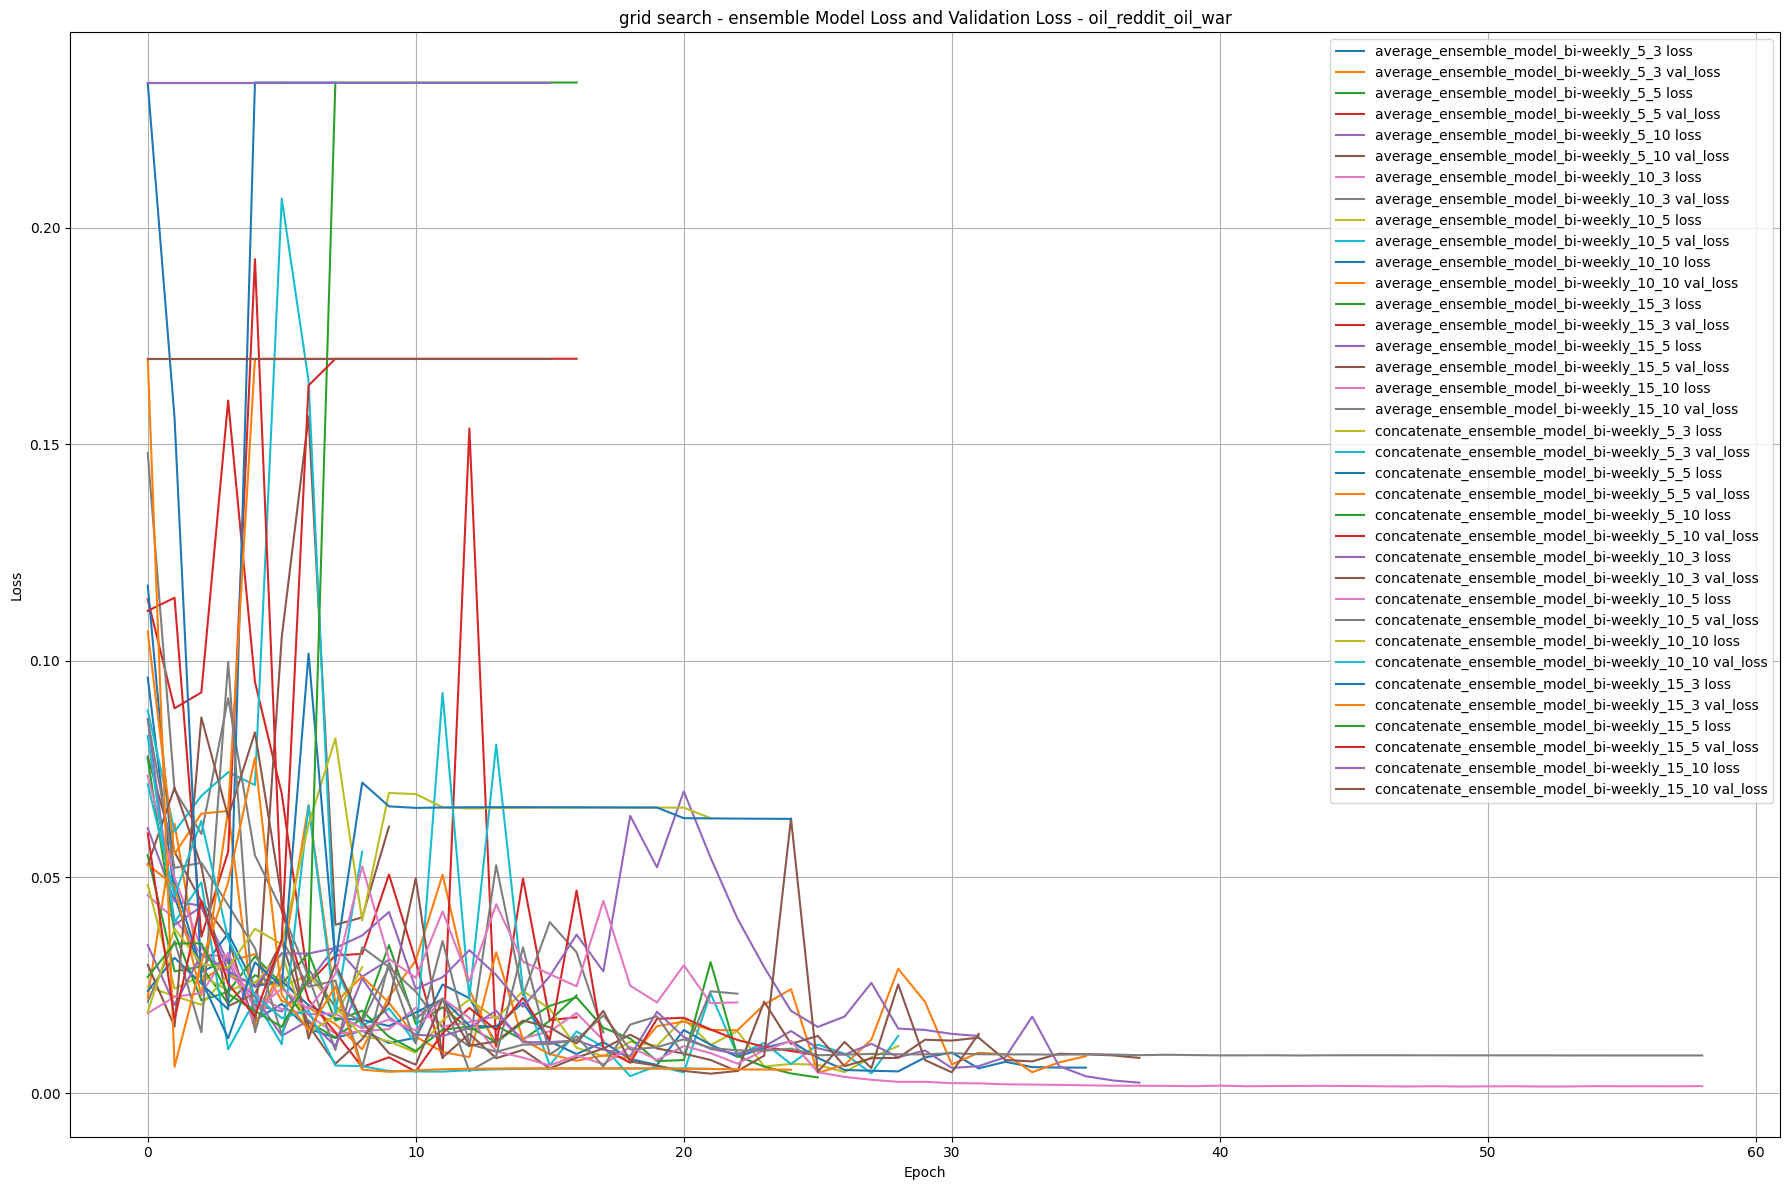

In [26]:
plt.figure(figsize=(18, 12))
for h in (histories):    # Plot Train vs Test Loss
    history=histories[h]
    plt.plot(history.history['loss'], label=f'{h} loss')
    plt.plot(history.history['val_loss'], label=f'{h} val_loss')

plt.title('grid search - ensemble Model Loss and Validation Loss - oil_reddit_oil_war')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(f'outputs/oil/ensemble model loss all models oil price only.png')

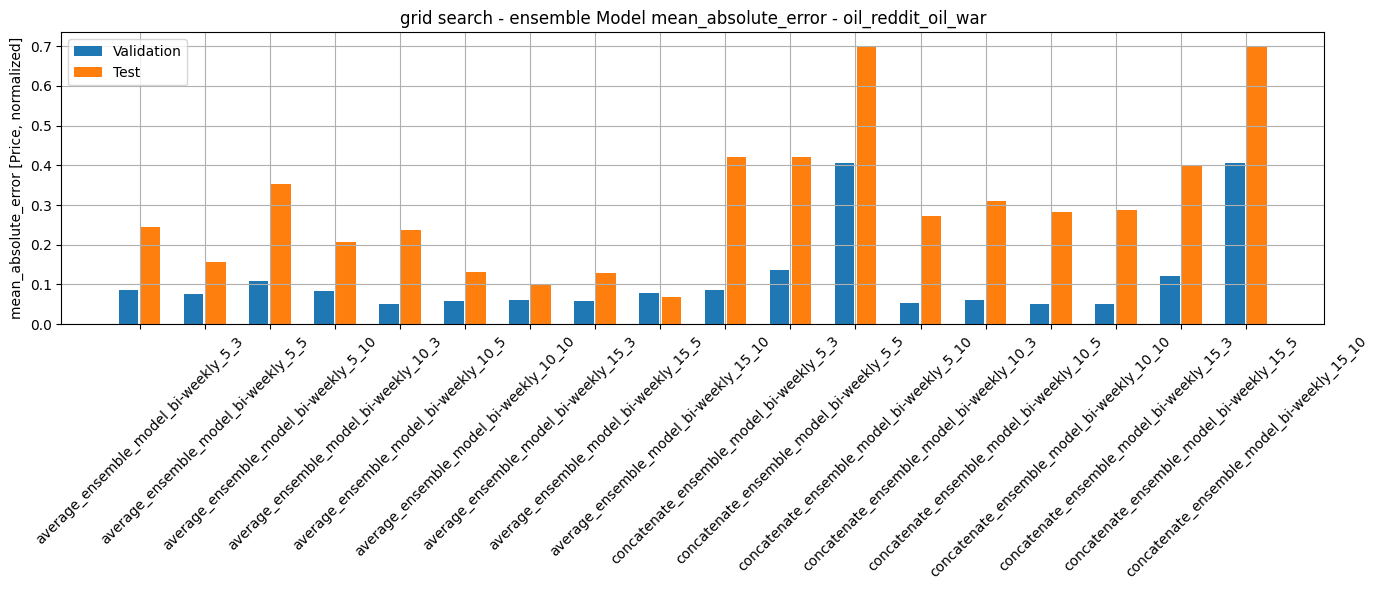

In [27]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.figure(figsize=(14, 6))
plt.title('grid search - ensemble Model mean_absolute_error - oil_reddit_oil_war')
plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()
# plt.savefig(f'outputs/oil/ensemble mean_absolute_error all models oil price only.png')


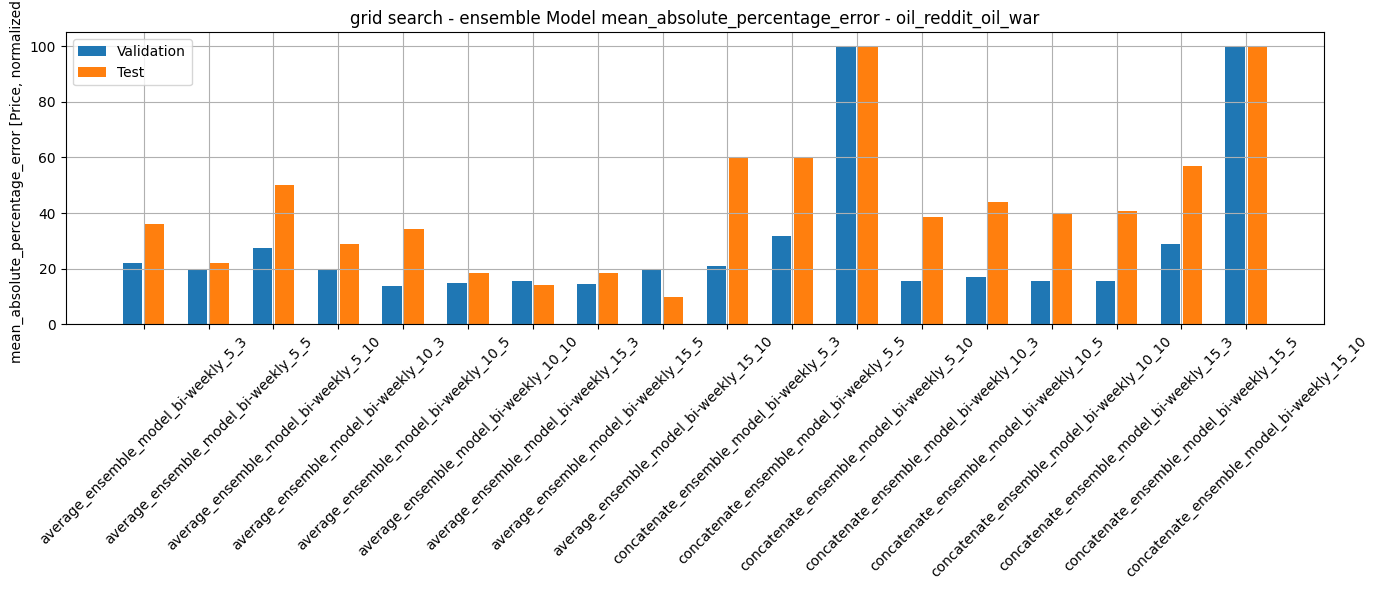

In [28]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('grid search - ensemble Model mean_absolute_percentage_error - oil_reddit_oil_war')
plt.ylabel('mean_absolute_percentage_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(f'outputs/oil/ensemble mean_absolute_percentage_error all models oil price only.png')

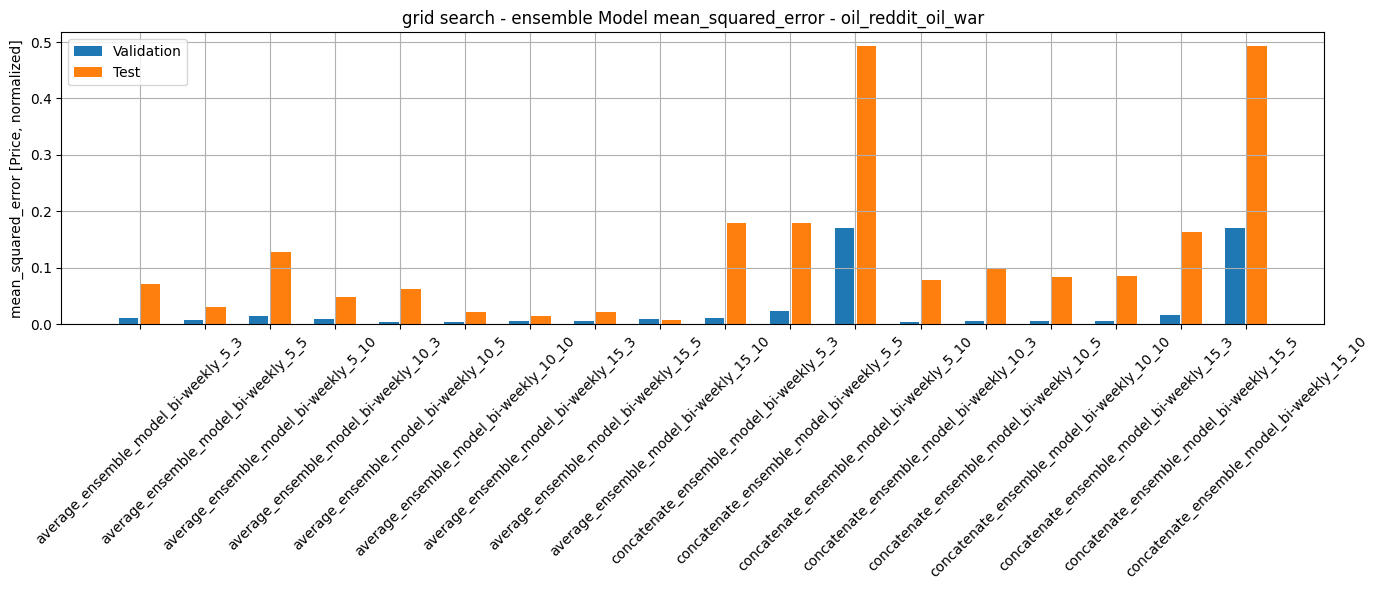

In [29]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error '
val_mae = [v['loss'] for v in val_performance.values()]
test_mae = [v['loss'] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('grid search - ensemble Model mean_squared_error - oil_reddit_oil_war')
plt.ylabel('mean_squared_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(f'outputs/oil/ensemble mean_squared_error all models oil price only.png')

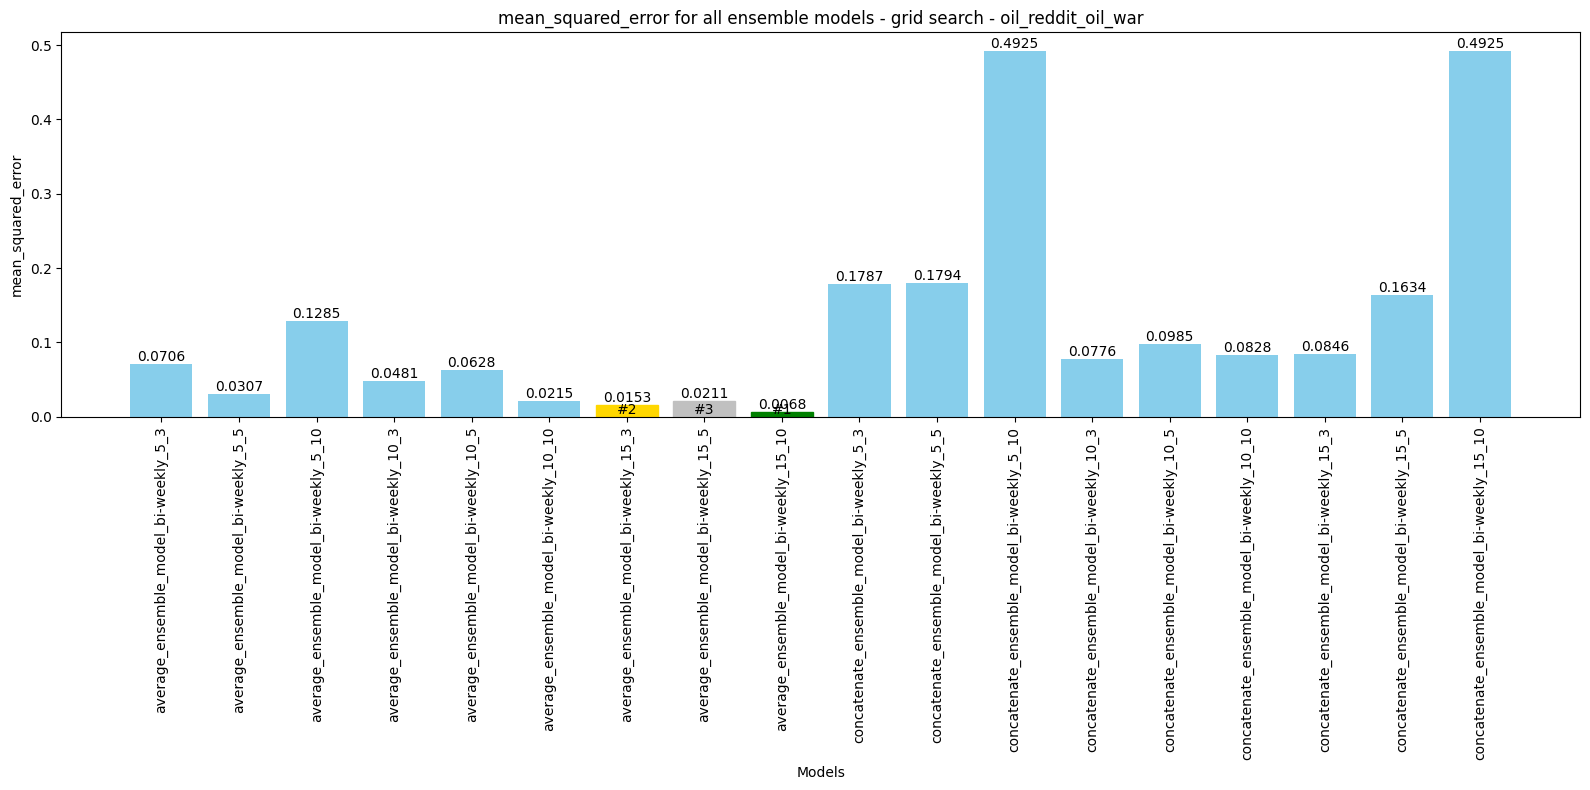

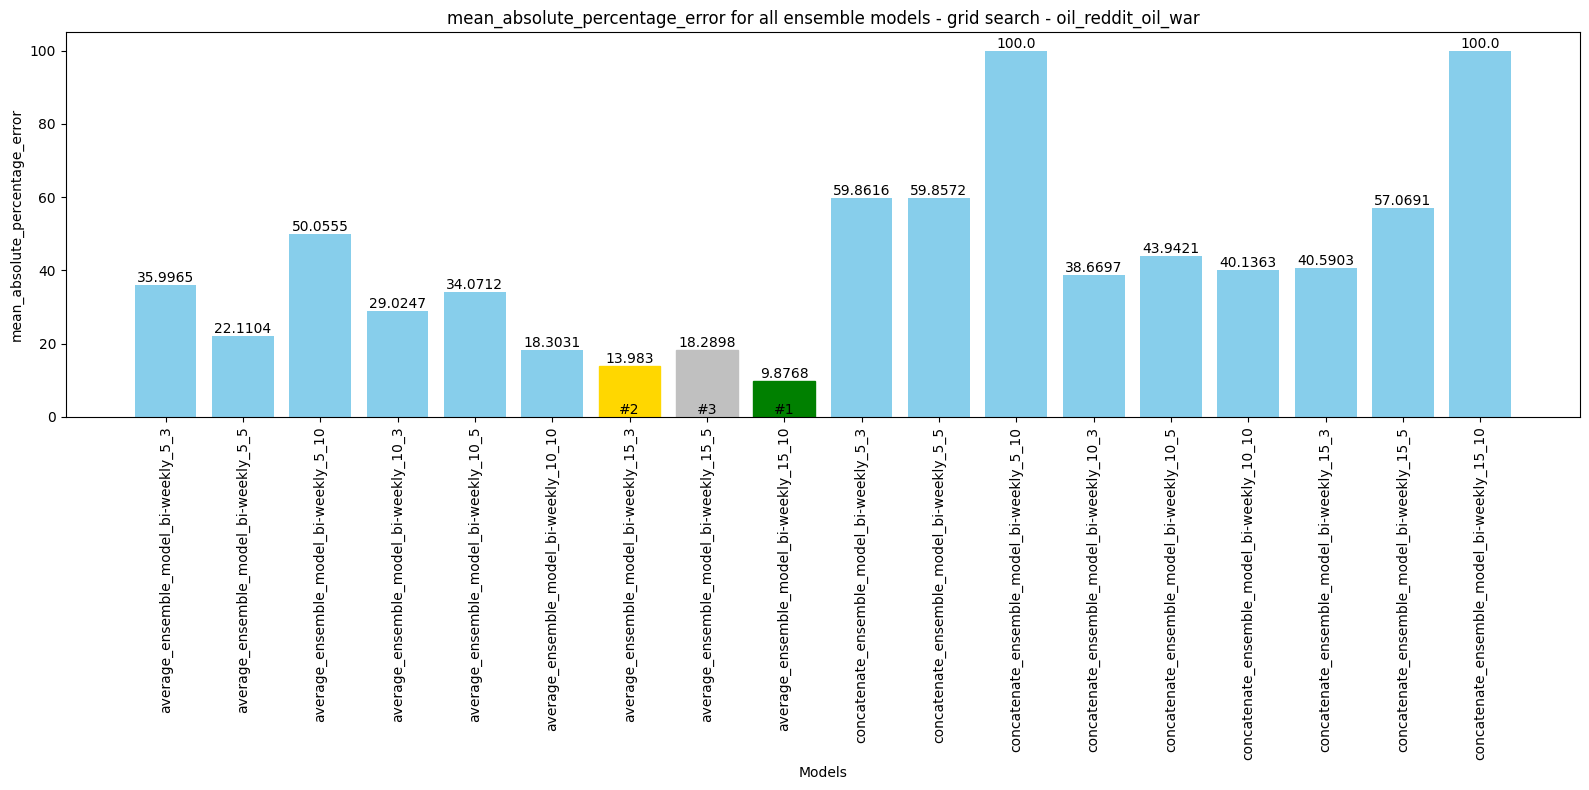

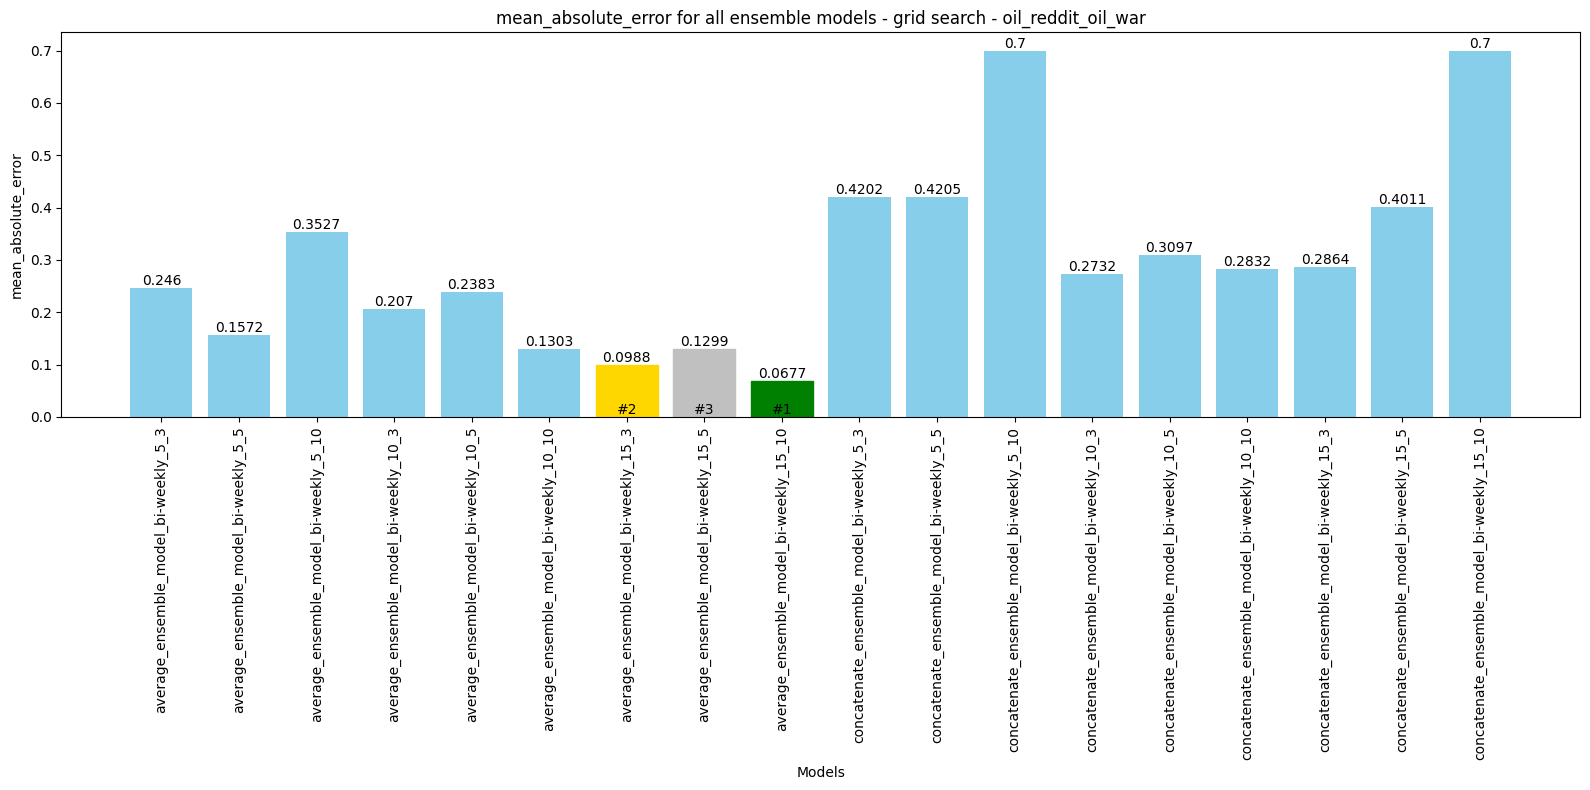

Top 3 models with minimum loss: ['average_ensemble_model_bi-weekly_15_10', 'average_ensemble_model_bi-weekly_15_3', 'average_ensemble_model_bi-weekly_15_5']
Top 3 models with minimum mean_absolute_error: ['average_ensemble_model_bi-weekly_15_10', 'average_ensemble_model_bi-weekly_15_3', 'average_ensemble_model_bi-weekly_15_5']
Top 3 models with minimum mean_squared_error: ['average_ensemble_model_bi-weekly_15_10', 'average_ensemble_model_bi-weekly_15_3', 'average_ensemble_model_bi-weekly_15_5']


In [30]:
# Extract data for each metric
models = list(performance.keys())
loss_values = [performance[model]['loss'] for model in models]
mae_values = [performance[model]['mean_absolute_percentage_error'] for model in models]
mse_values = [performance[model]['mean_absolute_error'] for model in models]

# Function to plot and save a metric, highlighting the best model
def plot_and_save_metric(metric_values, metric_name, best_models_indices):
    plt.figure(figsize=(16, 8))
    bars = plt.bar(models, metric_values, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for all ensemble models - grid search - oil_reddit_oil_war')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Highlight the best models with different colors
    colors = ['green', 'gold', 'silver']
    for rank, index in enumerate(best_models_indices):
        bars[index].set_color(colors[rank])
        yval = bars[index].get_height()

        plt.text(bars[index].get_x() + bars[index].get_width()/2,  0, f'#{rank+1}', ha='center', va='bottom')

    # Annotate all bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    # plt.savefig(f'outputs/oil/ensemble {metric_name}_comparison.png')
    plt.show()

# Find the indices of the top 3 models with the minimum values for each metric
top_n = 3

min_loss_indices = np.argsort(loss_values)[:top_n]
min_mae_indices = np.argsort(mae_values)[:top_n]
min_mse_indices = np.argsort(mse_values)[:top_n]
# Plot and save loss
plot_and_save_metric(loss_values, 'mean_squared_error', min_loss_indices)

# Plot and save mean_absolute_error
plot_and_save_metric(mae_values, 'mean_absolute_percentage_error', min_mae_indices)

# Plot and save mean_squared_error
plot_and_save_metric(mse_values, 'mean_absolute_error', min_mse_indices)

# Get the model names for the top 3 models
min_loss_models = [models[i] for i in min_loss_indices]
min_mae_models = [models[i] for i in min_mae_indices]
min_mse_models = [models[i] for i in min_mse_indices]

print(f'Top {top_n} models with minimum loss: {min_loss_models}')
print(f'Top {top_n} models with minimum mean_absolute_error: {min_mae_models}')
print(f'Top {top_n} models with minimum mean_squared_error: {min_mse_models}')

In [37]:
model_name='average_ensemble_model_bi-weekly_15_10' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
seq_length = models_list[model_name]['seq_length']

In [38]:
window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['Price']

In [39]:
seq_length

14

In [40]:
all_predict = model.predict(window.all_data)
print(all_predict.shape)

257/257 [==============================] - 1s 2ms/step
(257, 1)


In [41]:
all_predict[0]

array([0.29220065], dtype=float32)

257/257 [==============================] - 2s 2ms/step


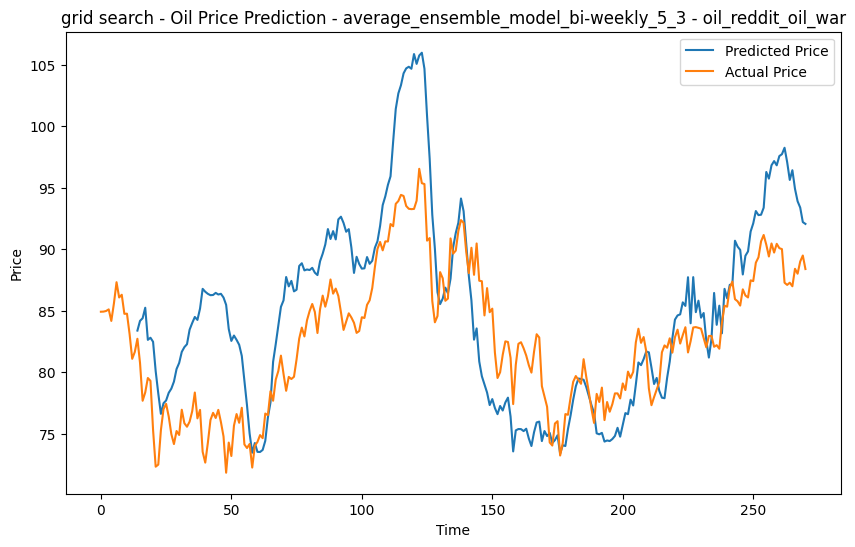

257/257 [==============================] - 2s 2ms/step


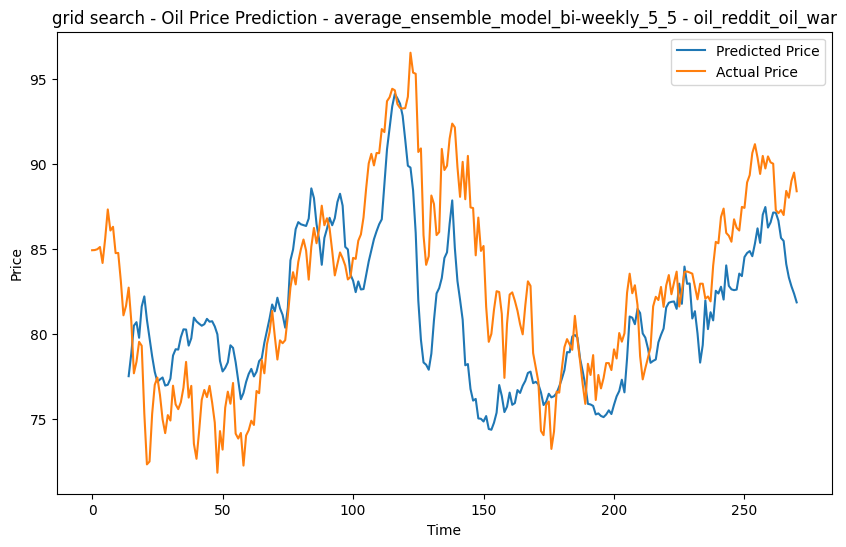

257/257 [==============================] - 2s 2ms/step


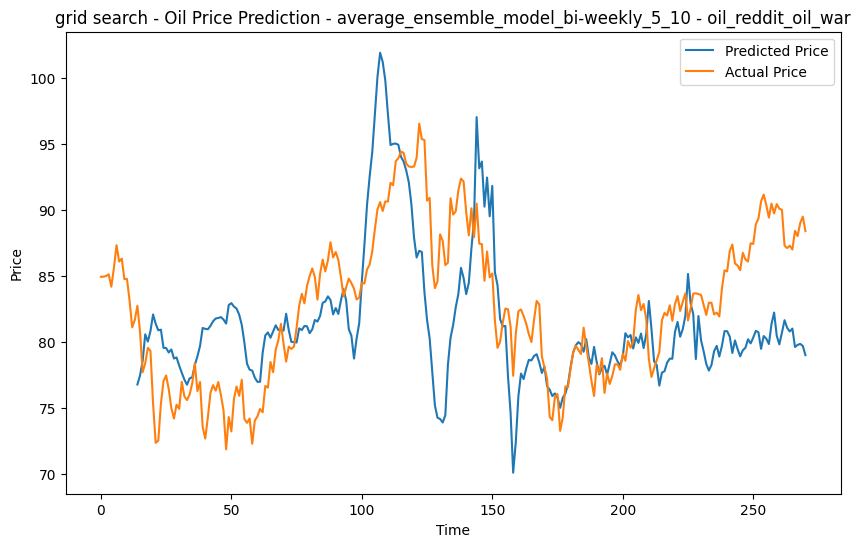

257/257 [==============================] - 2s 2ms/step


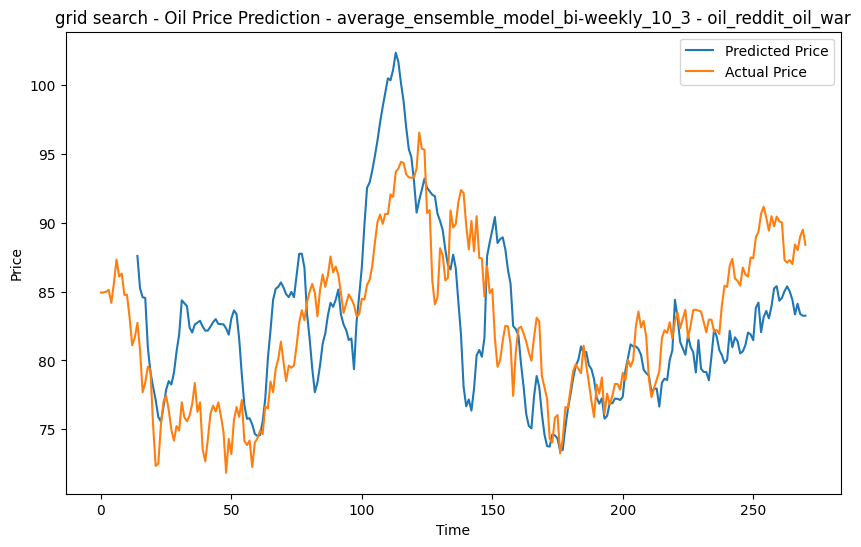

257/257 [==============================] - 2s 2ms/step


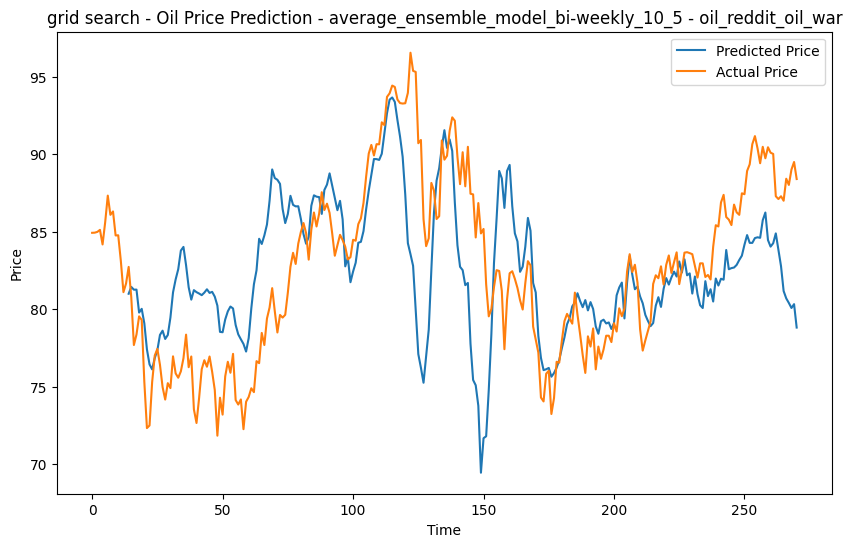

257/257 [==============================] - 2s 2ms/step


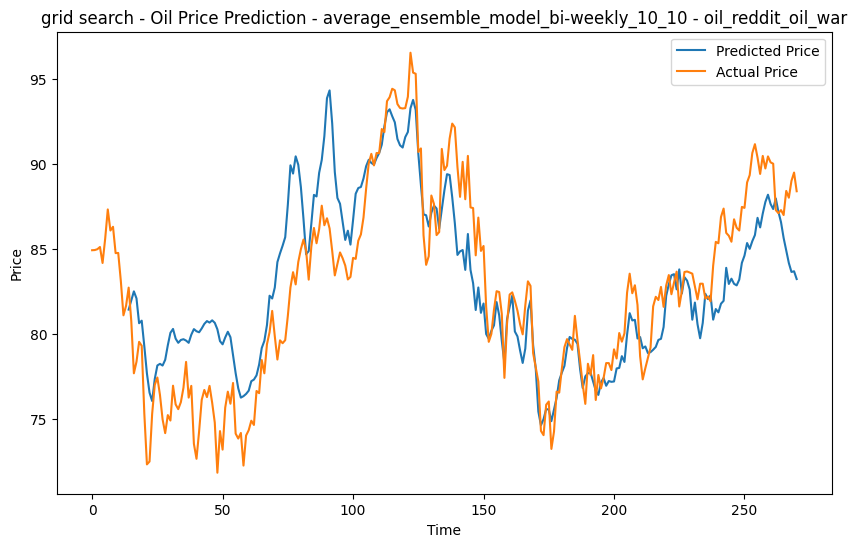

257/257 [==============================] - 0s 2ms/step


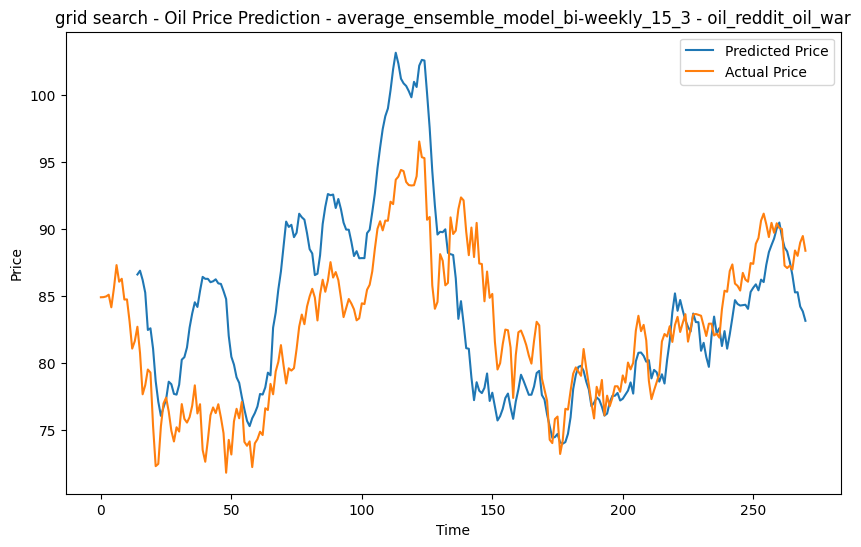

257/257 [==============================] - 2s 2ms/step


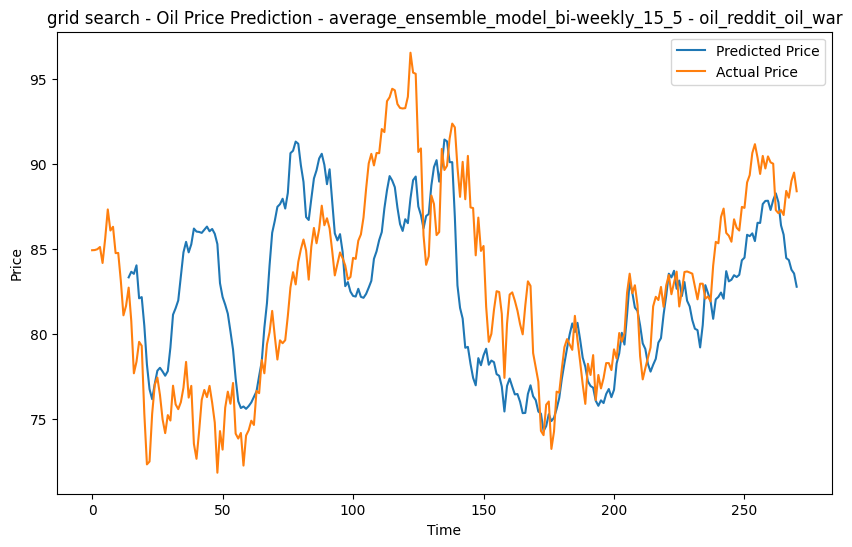

257/257 [==============================] - 2s 2ms/step


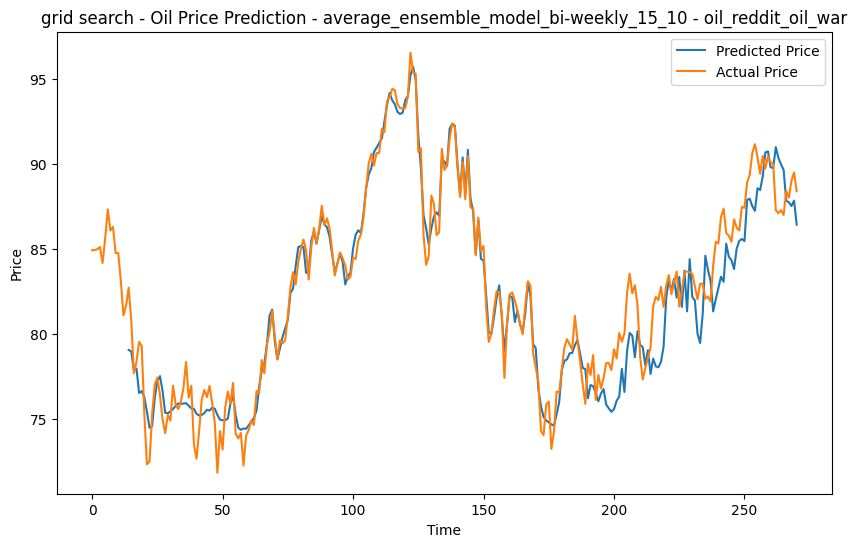

257/257 [==============================] - 2s 2ms/step


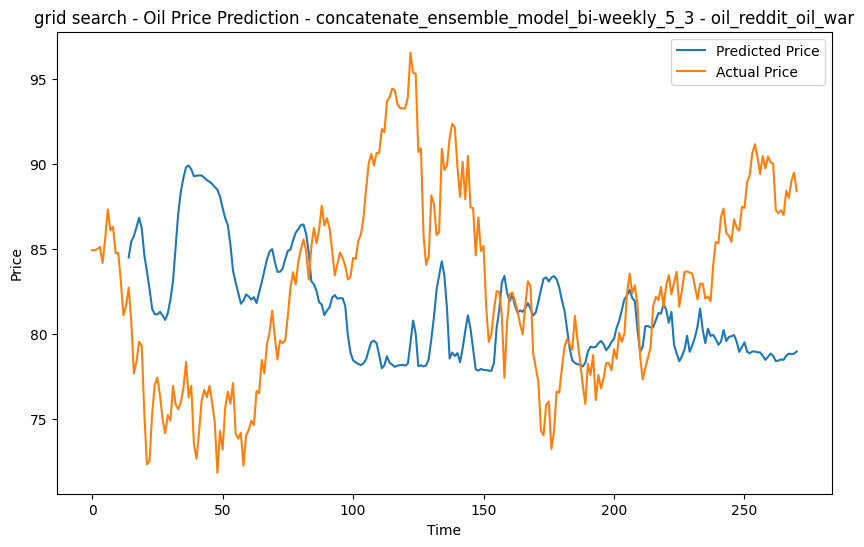

257/257 [==============================] - 2s 2ms/step


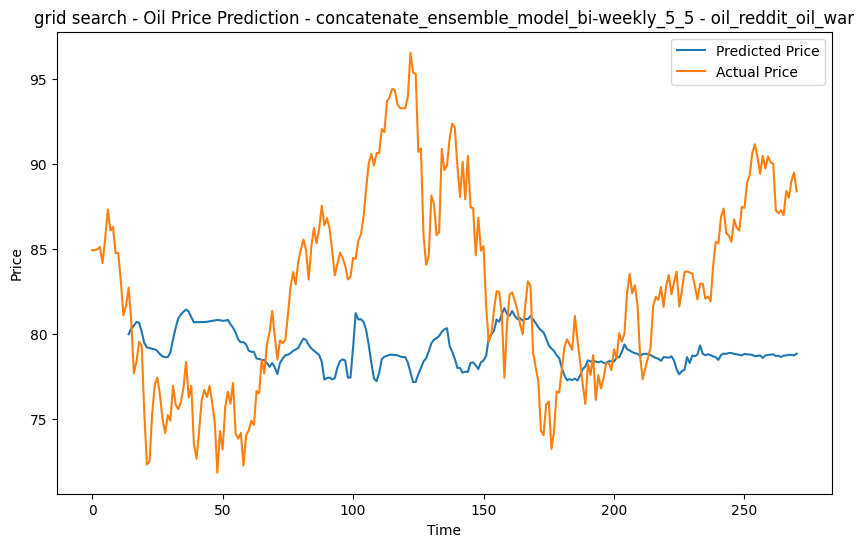

257/257 [==============================] - 2s 2ms/step


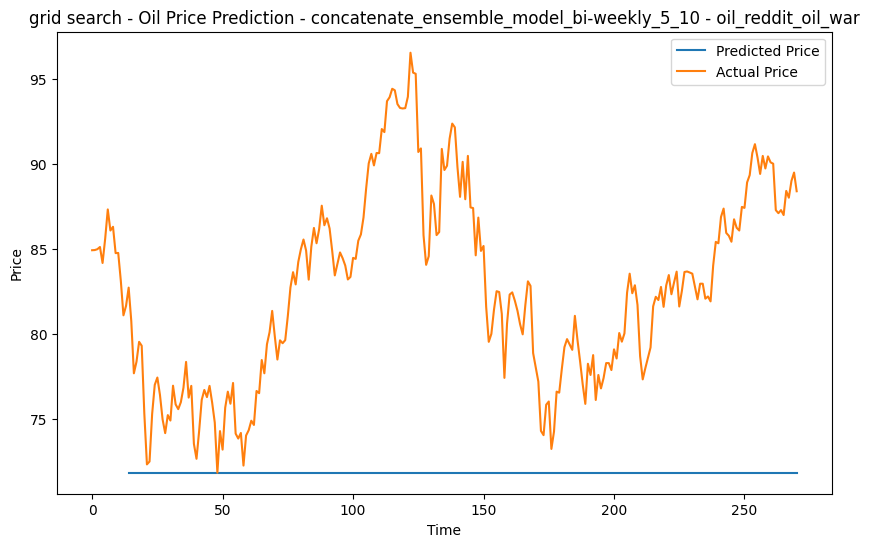

257/257 [==============================] - 2s 2ms/step


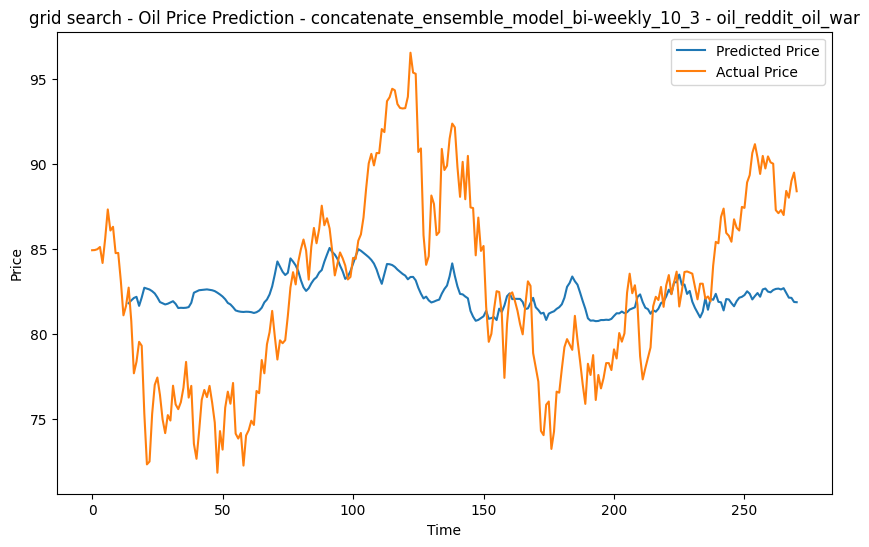

257/257 [==============================] - 2s 2ms/step


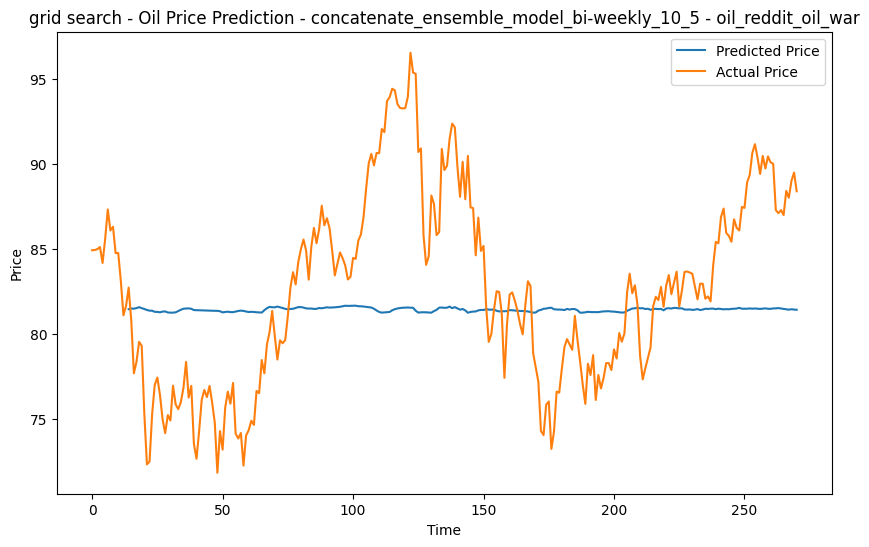

257/257 [==============================] - 2s 2ms/step


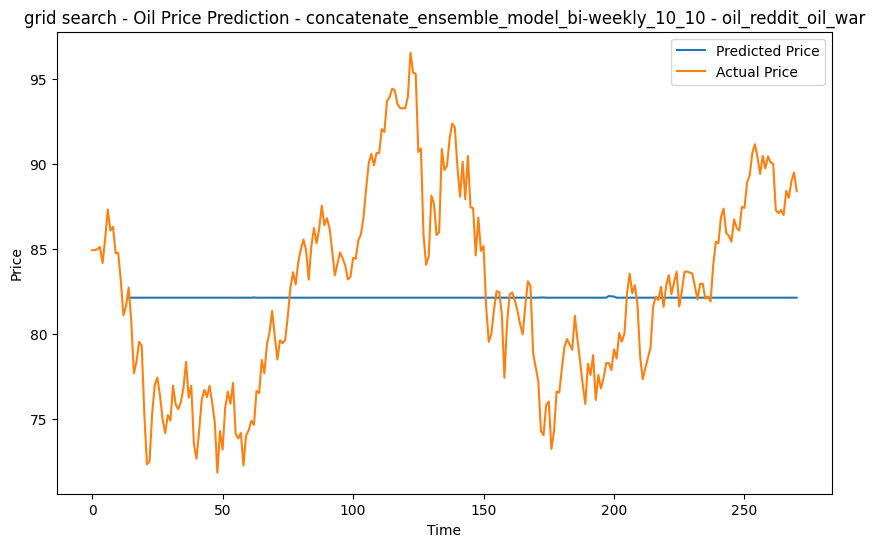

257/257 [==============================] - 2s 2ms/step


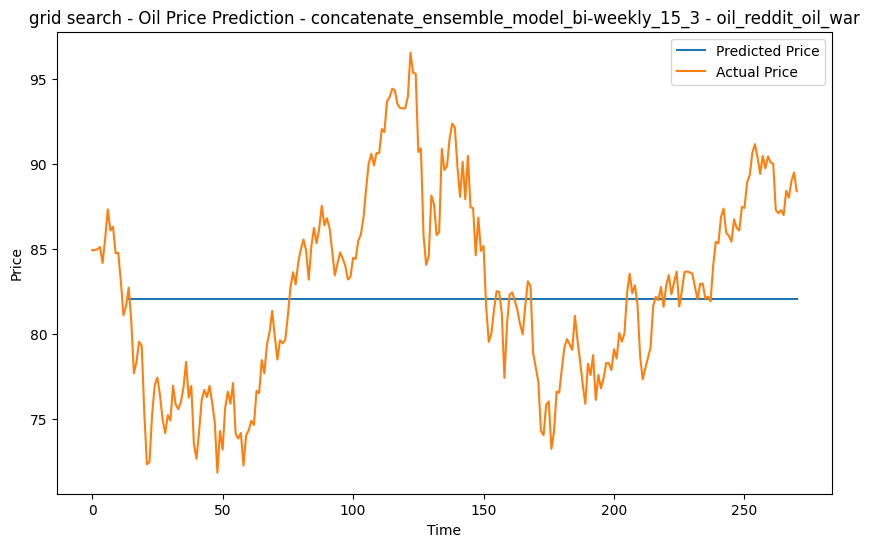

257/257 [==============================] - 2s 2ms/step


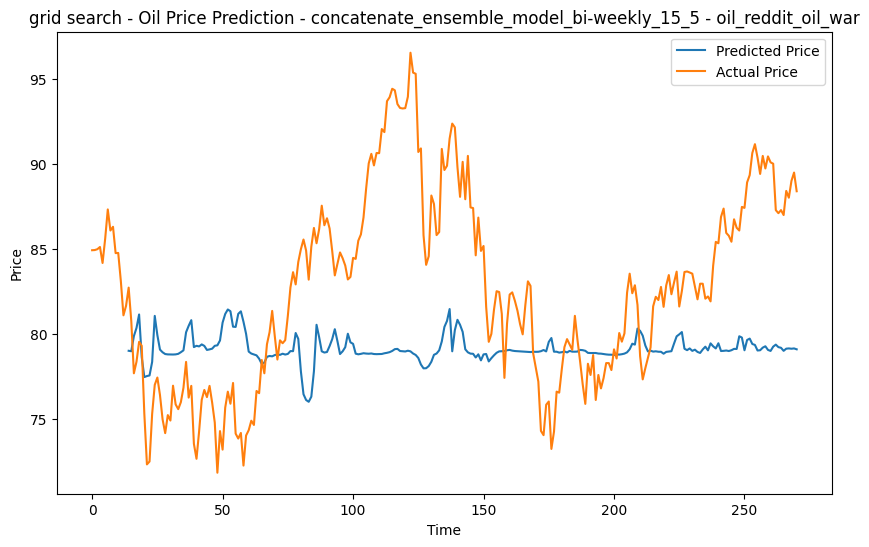

257/257 [==============================] - 2s 2ms/step


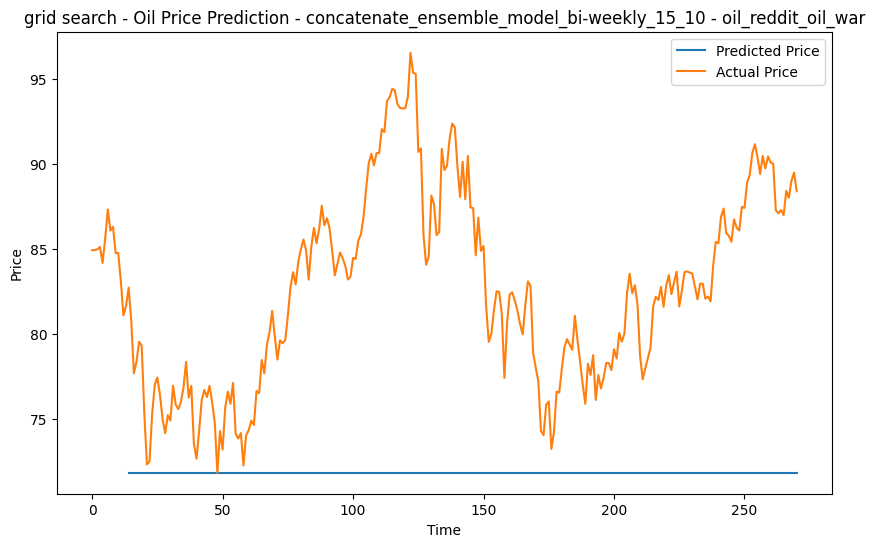

In [36]:
# Plot predictions vs actual values

# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    seq_length = models_list[model_name]['seq_length']

    all_predict = model.predict(window.all_data)
    try:

        X_all_data = scaler.inverse_transform(all_predict)

        plt.figure(figsize=(10, 6))
        plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
        plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
        plt.title(f'grid search - Oil Price Prediction - {model_name} - oil_reddit_oil_war')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        # plt.savefig(f'outputs/oil/ensemble {model_name} Oil Price Prediction.png')
        plt.show()
    except:
        print("Error", model_name, all_predict.shape)